In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark
import warnings

In [2]:
resolution = 1000  #grid resolution in meters
outPath = f"{os.curdir}{os.sep}output{os.sep}"
outputFileName = f"{outPath}AggregateLidarData_{resolution}m.parquet"
captureHoods = []


In [3]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [4]:
def lp(v, suppressOut=False):
    if not suppressOut:
        print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-29 13:39:10.451801] Starting...


In [5]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName(outputFileName).setMaster("spark://127.0.0.1:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-29 13:39:10.455734] Creating spark context


25/03/29 14:39:11 WARN Utils: Your hostname, G-ChaosStation resolves to a loopback address: 127.0.1.1; using 192.168.12.163 instead (on interface eno1)
25/03/29 14:39:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/29 14:39:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-29 13:39:12.849455] Path:  ./datasets/		FullPath:/home/g/Dev/NewOrleansElevation/datasets/


In [7]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
with laspy.open(f"{dataPath}laz{os.sep}{testLasFileName}", 'r') as f: 
    testLas = f.read()

[2025-03-29 13:39:12.857526] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0819n3342.laz to get crs and more


In [8]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

In [9]:
sorted(neighborhoodDf['gnocdc_lab'].unique())

['ALGIERS POINT',
 'AUDUBON',
 'B. W. COOPER',
 'BAYOU ST. JOHN',
 'BEHRMAN',
 'BLACK PEARL',
 'BROADMOOR',
 'BYWATER',
 'CENTRAL BUSINESS DISTRICT',
 'CENTRAL CITY',
 'CITY PARK',
 'DESIRE AREA',
 'DILLARD',
 'DIXON',
 'EAST CARROLLTON',
 'EAST RIVERSIDE',
 'FAIRGROUNDS',
 'FILMORE',
 'FISCHER DEV',
 'FLORIDA AREA',
 'FLORIDA DEV',
 'FRENCH QUARTER',
 'FRERET',
 'GARDEN DISTRICT',
 'GENTILLY TERRACE',
 'GENTILLY WOODS',
 'GERT TOWN',
 'HOLLYGROVE',
 'HOLY CROSS',
 'IBERVILLE',
 'IRISH CHANNEL',
 'LAKE CATHERINE',
 'LAKE TERRACE & OAKS',
 'LAKESHORE - LAKE VISTA',
 'LAKEVIEW',
 'LAKEWOOD',
 'LEONIDAS',
 'LITTLE WOODS',
 'LOWER GARDEN DISTRICT',
 'LOWER NINTH WARD',
 'MARIGNY',
 'MARLYVILLE - FONTAINEBLEAU',
 'MID-CITY',
 'MILAN',
 'MILNEBURG',
 'McDONOGH',
 'NAVARRE',
 'NEW AURORA - ENGLISH TURN',
 'OLD AURORA',
 'PINES VILLAGE',
 'PLUM ORCHARD',
 'PONTCHARTRAIN PARK',
 'READ BLVD EAST',
 'READ BLVD WEST',
 'SEVENTH WARD',
 'ST.  ANTHONY',
 'ST. BERNARD AREA',
 'ST. CLAUDE',
 'ST. ROCH

In [10]:
if len(captureHoods) > 0:
    captureHoodsMask = neighborhoodDf['gnocdc_lab'].isin(captureHoods)
else:
    captureHoodsMask = np.repeat(True, neighborhoodDf.shape[0])

<Axes: >

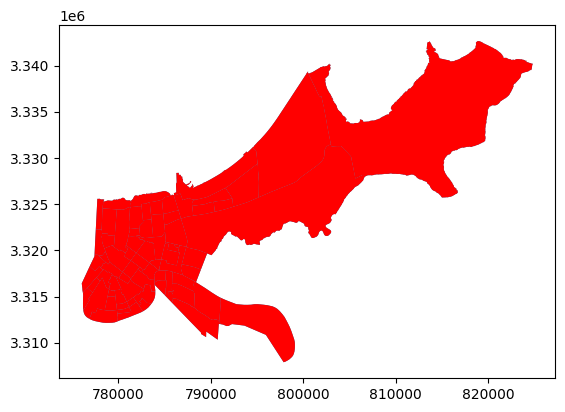

In [11]:
ax = neighborhoodDf.plot()
neighborhoodDf[captureHoodsMask].plot(ax=ax, color='red')

In [12]:
bounds = [int(b) for b in neighborhoodDf[captureHoodsMask].total_bounds]

In [13]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-29 13:39:14.138194] Resolution will be 48.807 x 34.758  Runtime based on 1696.4337060000003


In [14]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf[captureHoodsMask].union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Int'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()


<Axes: >

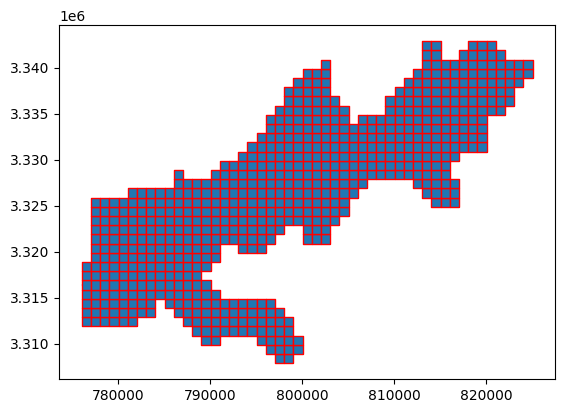

In [15]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [16]:
tileIndex = gpd.read_file(f"{dataPath}USGS_LA_2021GNO_1_C22_TileIndex{os.sep}USGS_LA_2021GNO_1_C22_TileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['Name'].map(lambda f: f"{fullDataPath}laz{os.sep}USGS_LPC_LA_2021GreaterNewOrleans_C22_{f}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex)
tileIndexBroadcast.value.head()

,Name,Comment,PRJ_ID,WU_ID,WU_Name,geometry
Name,,,,,,
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz,w0809n3329,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((810000 3329000, 809000 3329000, 8090..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0755n3296.laz,w0755n3296,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((756000 3296000, 755000 3296000, 7550..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0673n3303.laz,w0673n3303,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((674000 3303000, 673500 3303000, 6735..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0704n3295.laz,w0704n3295,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((705000 3295000, 704000 3295000, 7040..."
/home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0748n3320.laz,w0748n3320,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((749000 3320000, 748000 3320000, 7480..."


In [17]:

def processLas(inputTup, suppressOut=True):
    startTime = datetime.now()
    
    BoxIdx = inputTup[0]
    boxBounds = inputTup[1:]
    
    lp(f"Processing[{BoxIdx}] bounds {boxBounds}",suppressOut)

    altTotal = 0
    waterTotal = 0
    pointTotal = 0
    intenseTotal = 0
    for idx, row in tileIndexBroadcast.value.iterrows():
        if not row['geometry'].intersects(shapely.box(*boxBounds)):
            #no intersection scip
            continue

        try:
            with laspy.open(idx, 'r') as f:
                las = f.read()
        except FileNotFoundError:
            warnings.warn(f"path {idx} does not exist skipping" )
            continue
        
        transBoxBounds = (  int((boxBounds[0] - las.header.offsets[0]) / las.header.scales[0]),\
                            int((boxBounds[1] - las.header.offsets[1]) / las.header.scales[1]),\
                            int((boxBounds[2] - las.header.offsets[0]) / las.header.scales[0]),\
                            int((boxBounds[3] - las.header.offsets[1]) / las.header.scales[1]),)

        
        lp(f"LAZ Bounds         = ({las.header.mins[0]},{las.header.mins[1]},{las.header.maxs[0]},{las.header.maxs[1]})",suppressOut)
        lp(f"LAZ Unscale Bounds = ({las.X.min()},{las.Y.min()},{las.X.max()},{las.y.max()})",suppressOut)
        lp(f"newBox:  {transBoxBounds}", suppressOut)
        
        X = las.X
        Y = las.Y
        Z = las.Z
        cls = las.classification
        intense = las.intensity

                
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (transBoxBounds[0]), (X <= (transBoxBounds[2])))
        lp(f"InBoundsX:  {np.count_nonzero(inBoundsMaskX)}", suppressOut)
        inBoundsMaskY = np.logical_and(Y >= (transBoxBounds[1]), (Y <= (transBoxBounds[3])))
        lp(f"InBoundsY:  {np.count_nonzero(inBoundsMaskY)}", suppressOut)
        inBoundsMask = np.logical_and(inBoundsMaskX,inBoundsMaskY)
        lp(f"InBounds:  {np.count_nonzero(inBoundsMask)}", suppressOut)
        goodPointMask = np.logical_and( groundMask, inBoundsMask)
        
        lp(f"Good points / Total {np.count_nonzero(goodPointMask)}/{goodPointMask.shape[0]}", suppressOut)
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        intenseTotal += int(intense[goodPointMask].sum())
        pointTotal += np.count_nonzero(goodPointMask)

    return (BoxIdx,altTotal, waterTotal, intenseTotal, pointTotal, datetime.now() - startTime)


In [18]:
#Just for sanity
values = [0,1,2,3,4,25,100,200,220]
lp(f"Sanity checks for indexes:  {values}")
for i in values:
    print(f"{i} = {processLas(list(boxesDf.bounds.itertuples())[i], False)}")


[2025-03-29 13:39:15.234147] Sanity checks for indexes:  []
[2025-03-29 13:39:15.235815] Processing[4] bounds (776039.0, 3311888.0, 777039.0, 3312888.0)
[2025-03-29 13:39:16.068573] LAZ Bounds         = (777000.001,3312000.001,778000.0,3312999.9990000003)
[2025-03-29 13:39:16.114626] LAZ Unscale Bounds = (777000001,-499999,778000000,3312999.999)
[2025-03-29 13:39:16.114714] newBox:  (776039000, -612000, 777039000, 388000)
[2025-03-29 13:39:16.203627] InBoundsX:  166270
[2025-03-29 13:39:16.234171] InBoundsY:  3234959
[2025-03-29 13:39:16.237481] InBounds:  109534
[2025-03-29 13:39:16.239317] Good points / Total 31475/4611641
[2025-03-29 13:39:17.108753] LAZ Bounds         = (776000.0,3312000.0,777000.0,3312999.9990000003)
[2025-03-29 13:39:17.160830] LAZ Unscale Bounds = (776000000,-500000,777000000,3312999.999)
[2025-03-29 13:39:17.160880] newBox:  (776039000, -612000, 777039000, 388000)
[2025-03-29 13:39:17.265036] InBoundsX:  5796870
[2025-03-29 13:39:17.293231] InBoundsY:  5826931


/tmp/ipykernel_416390/1954683479.py:22: UserWarning: path /home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0776n3311.laz does not exist skipping
  warnings.warn(f"path {idx} does not exist skipping" )
/tmp/ipykernel_416390/1954683479.py:22: UserWarning: path /home/g/Dev/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0777n3311.laz does not exist skipping
  warnings.warn(f"path {idx} does not exist skipping" )


0 = (4, 3124952105, 845, 1218623103, 1588830, datetime.timedelta(seconds=2, microseconds=344735))
[2025-03-29 13:39:17.582482] Processing[5] bounds (776039.0, 3312888.0, 777039.0, 3313888.0)
[2025-03-29 13:39:19.672263] LAZ Bounds         = (777000.001,3313000.0,778000.0,3313999.9990000003)
[2025-03-29 13:39:19.836262] LAZ Unscale Bounds = (777000001,-500000,778000000,3313999.999)
[2025-03-29 13:39:19.836311] newBox:  (776039000, -612000, 777039000, 388000)
[2025-03-29 13:39:20.016565] InBoundsX:  470261
[2025-03-29 13:39:20.088167] InBoundsY:  13047825
[2025-03-29 13:39:20.092564] InBounds:  425096
[2025-03-29 13:39:20.096998] Good points / Total 87965/14847494
[2025-03-29 13:39:20.745263] LAZ Bounds         = (777000.001,3312000.001,778000.0,3312999.9990000003)
[2025-03-29 13:39:20.788693] LAZ Unscale Bounds = (777000001,-499999,778000000,3312999.999)
[2025-03-29 13:39:20.788744] newBox:  (776039000, 388000, 777039000, 1388000)
[2025-03-29 13:39:20.850148] InBoundsX:  166270
[2025-03

In [19]:
boxesRdd = sc.parallelize(boxesDf.bounds.itertuples(), 300)

In [20]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [21]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-29 13:40:15.396222] 648 boxes total


In [22]:
output = boxesProcessedRdd.collect()

In [23]:
sc.stop()

In [24]:
output[0]

(4,
 3124952105,
 845,
 1218623103,
 1588830,
 datetime.timedelta(seconds=7, microseconds=233485))

In [25]:
for out in output:
    boxesDf.loc[out[0], 'AltitudeTotal'] = out[1]
    boxesDf.loc[out[0], 'WaterTotal'] = out[2]
    boxesDf.loc[out[0], 'Int'] = out[3]
    boxesDf.loc[out[0], 'Total'] = out[4]
    boxesDf.loc[out[0], 'RunTime'] = out[5]

In [26]:
lp(f"{boxesDf['RunTime'].mean()} avg runtime\t\ttotal:  {boxesDf['RunTime'].sum()}")

[2025-03-29 14:22:19.896292] 0 days 00:00:15.416313 avg runtime		total:  0 days 02:46:29.771214


In [27]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",3.124952e+09,845.0,1.218623e+09,1588830.0,0 days 00:00:07.233485
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",6.639287e+09,911.0,1.180152e+09,1289143.0,0 days 00:00:16.606501
6,"POLYGON ((777039 3313888, 777039 3314888, 7760...",4.592980e+09,7657.0,9.553016e+08,1359746.0,0 days 00:00:23.685434
7,"POLYGON ((777039 3314888, 777039 3315888, 7760...",3.447446e+09,1599.0,7.301208e+08,1165901.0,0 days 00:00:22.202606
8,"POLYGON ((777039 3315888, 777039 3316888, 7760...",3.901736e+09,2183.0,8.661724e+08,1620405.0,0 days 00:00:24.130045


In [28]:
boxesDf.to_parquet(outputFileName)

In [29]:
with open(f"{outPath}FinishTime_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

<Axes: >

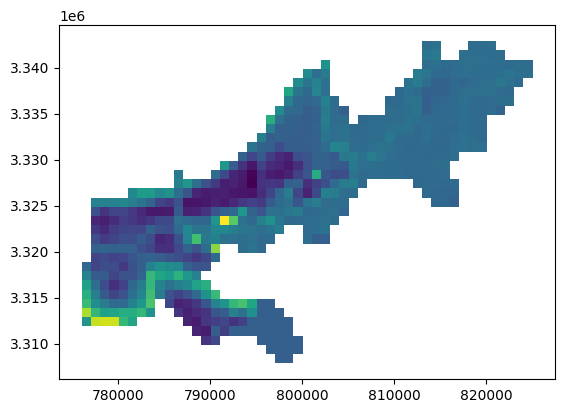

In [31]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='AltCalc',ax=ax)

<Axes: >

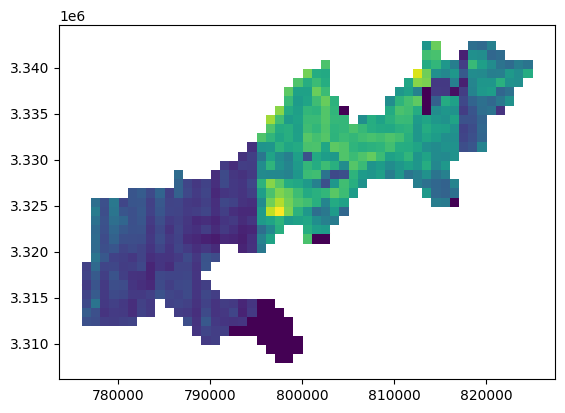

In [32]:
boxesDf['IntCalc'] = boxesDf['Int'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['IntCalc']),'IntCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='IntCalc',ax=ax)

In [33]:
lp("Done!")

[2025-03-29 14:22:51.550060] Done!


In [35]:
!aws s3 cp $outputFileName s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/

upload: output/AggregateLidarData_1000m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/AggregateLidarData_1000m.parquet
